<a href="https://colab.research.google.com/github/kareemrb27/GenAIIK/blob/main/Sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from transformers import AutoTokenizer, GPT2LMHeadModel
import torch

tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
model = GPT2LMHeadModel.from_pretrained("openai-community/gpt2")

text = "Once upon a time"
input_ids = tokenizer.encode(text, return_tensors='pt')

T = 10
outputs = model.generate(input_ids, max_new_tokens = T)

generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
print(f"Generated text: {generated_text}")

Generated text: Once upon a time, the world was a place of great beauty and


In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model.eval()

text = "I have a dream"
input_ids = tokenizer.encode(text, return_tensors='pt').to(device)

outputs = model.generate(input_ids, max_length=len(input_ids.squeeze())+5)
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
print(f"Generated text: {generated_text}")

Generated text: I have a dream of being a doctor.


# Let's Call model() instead

In [ ]:
output = model(input_ids)

In [ ]:
input_ids

tensor([[  40,  423,  257, 4320]])

In [ ]:
output.logits.shape

torch.Size([1, 4, 50257])

In [ ]:
pred = output.logits[0, -1, :]
print(pred.shape)
print(torch.argmax(pred))

torch.Size([50257])
tensor(286)


# Greedy Search

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import time

def get_log_prob(logits, token_id):
    # Compute the softmax of the logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    log_probabilities = torch.log(probabilities)

    # Get the log probability of the token
    token_log_probability = log_probabilities[token_id].item()
    return token_log_probability

def get_predicted_logits(model, input_ids):
  outputs = model(input_ids)
  predictions = outputs.logits

  # Get the predicted next sub-word (here we use top-k search)
  logits = predictions[0, -1, :]
  return logits

def greedy_search(input_ids, node, length=5):
    if length == 0:
        return input_ids
    print(input_ids)
    logits = get_predicted_logits(model, input_ids)

    ### This is where we choose (sample) the next token ###
    token_id = torch.argmax(logits).unsqueeze(0)

    # Compute the score of the predicted token
    token_score = get_log_prob(logits, token_id)

    # Add the predicted token to the list of input ids
    new_input_ids = torch.cat([input_ids, token_id.unsqueeze(0)], dim=-1)

    # Plotting logic ... you can ignore it
    # Add node and edge to graph
    next_token = tokenizer.decode(token_id, skip_special_tokens=True)
    current_node = list(graph.successors(node))[0]
    graph.nodes[current_node]['tokenscore'] = np.exp(token_score) * 100
    graph.nodes[current_node]['token'] = next_token + f"_{length}"

    # Recursive call
    input_ids = greedy_search(new_input_ids, current_node, length-1)

    return input_ids

# Parameters
length = 5
beams = 1

# Create a balanced tree with height 'length'
graph = nx.balanced_tree(1, length, create_using=nx.DiGraph())

# Add 'tokenscore', 'cumulative_score', and 'token' attributes to each node
for node in graph.nodes:
    graph.nodes[node]['tokenscore'] = 100
    graph.nodes[node]['token'] = text

# Start generating text
output_ids = greedy_search(input_ids, 0, length=length)
output = tokenizer.decode(output_ids.squeeze().tolist(), skip_special_tokens=True)
print(f"Generated text: {output}")

tensor([[  40,  423,  257, 4320]])
tensor([[  40,  423,  257, 4320,  286]])
tensor([[  40,  423,  257, 4320,  286,  852]])
tensor([[  40,  423,  257, 4320,  286,  852,  257]])
tensor([[  40,  423,  257, 4320,  286,  852,  257, 6253]])
Generated text: I have a dream of being a doctor.


# Plotting Logic

In [ ]:
!apt install libgraphviz-dev
!pip install pygraphviz
# !pip install graphviz
# !apt-get install graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


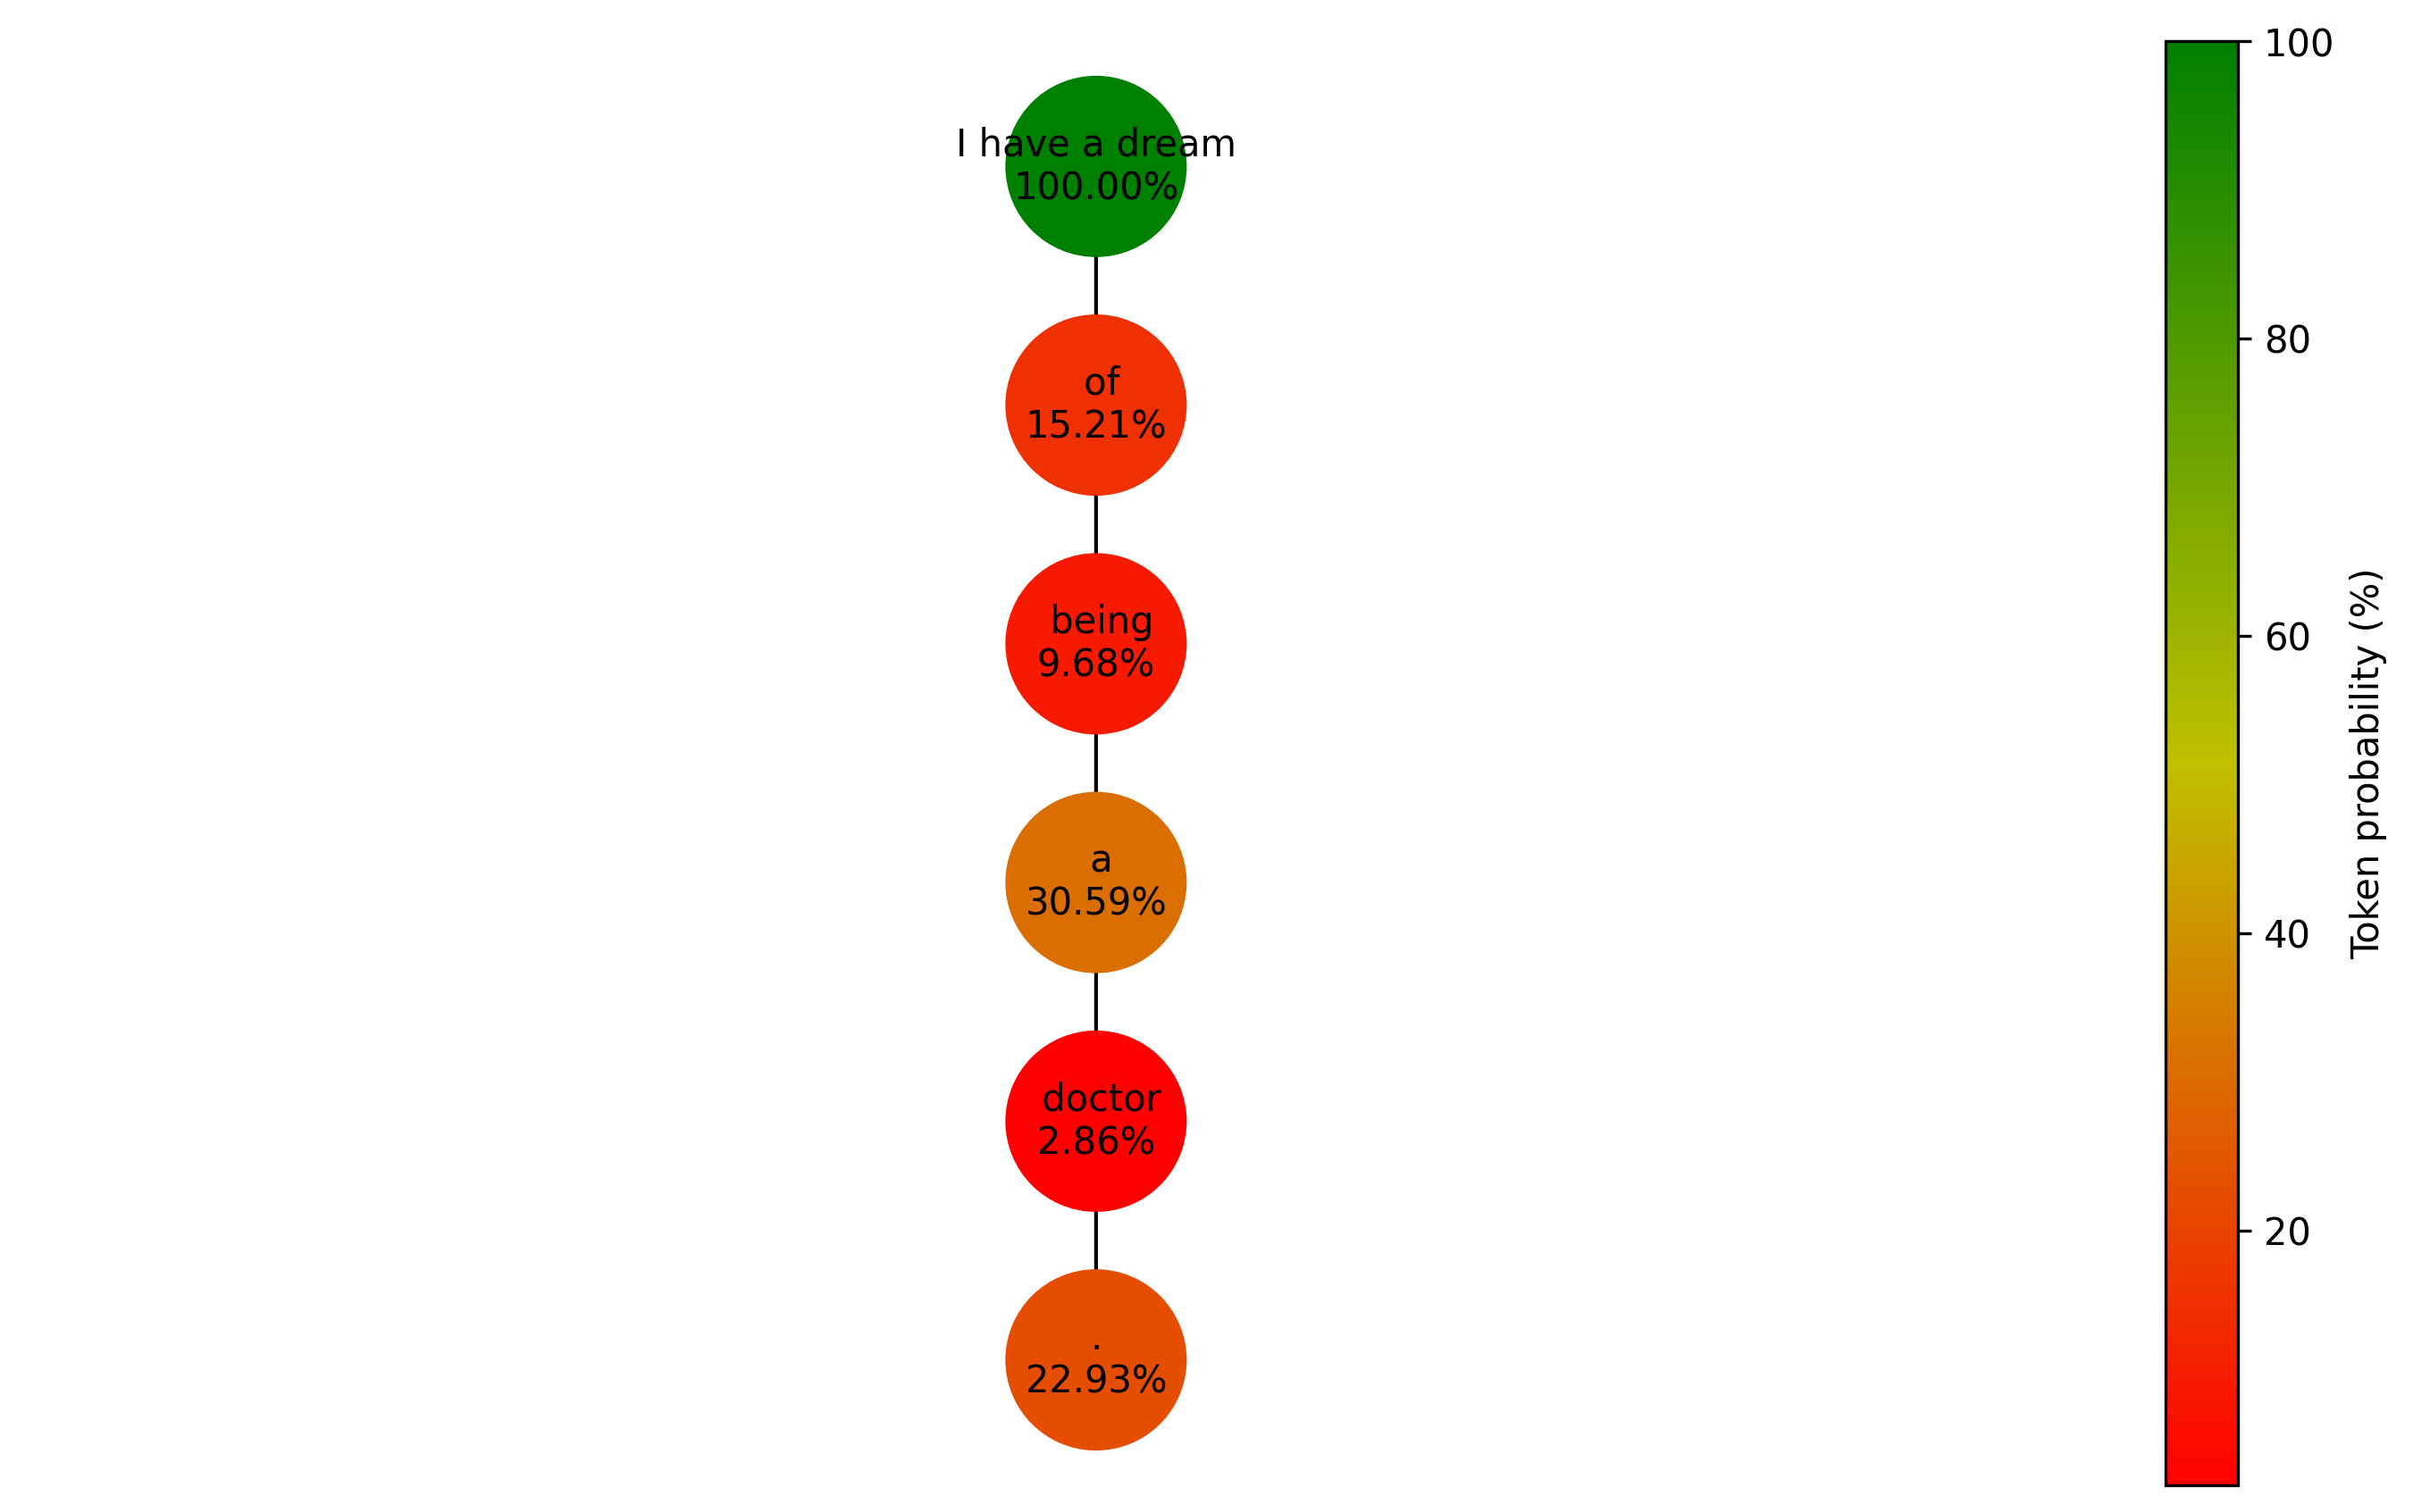

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

def plot_graph(graph, length, beams, score):
    fig, ax = plt.subplots(figsize=(3+1.2*beams**length, max(5, 2+length)), dpi=300, facecolor='white')

    # Create positions for each node
    pos = nx.nx_agraph.graphviz_layout(graph, prog="dot")

    # Normalize the colors along the range of token scores
    if score == 'token':
        scores = [data['tokenscore'] for _, data in graph.nodes(data=True) if data['token'] is not None]
    elif score == 'sequence':
        scores = [data['sequencescore'] for _, data in graph.nodes(data=True) if data['token'] is not None]
    vmin = min(scores)
    vmax = max(scores)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = LinearSegmentedColormap.from_list('rg', ["r", "y", "g"], N=256)

    # Draw the nodes
    nx.draw_networkx_nodes(graph, pos, node_size=2000, node_shape='o', alpha=1, linewidths=4,
                          node_color=scores, cmap=cmap)

    # Draw the edges
    nx.draw_networkx_edges(graph, pos)

    # Draw the labels
    if score == 'token':
        labels = {node: data['token'].split('_')[0] + f"\n{data['tokenscore']:.2f}%" for node, data in graph.nodes(data=True) if data['token'] is not None}
    elif score == 'sequence':
        labels = {node: data['token'].split('_')[0] + f"\n{data['sequencescore']:.2f}" for node, data in graph.nodes(data=True) if data['token'] is not None}
    nx.draw_networkx_labels(graph, pos, labels=labels, font_size=10)
    plt.box(False)

    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    if score == 'token':
        fig.colorbar(sm, ax=ax, orientation='vertical', pad=0, label='Token probability (%)')
    elif score == 'sequence':
        fig.colorbar(sm, ax=ax, orientation='vertical', pad=0, label='Sequence score')
    plt.show()

# Plot graph
plot_graph(graph, length, 1.5, 'token')

# Beam Search

In [ ]:
from tqdm.notebook import tqdm

def greedy_sampling(logits, beams):
    return torch.topk(logits, beams).indices

def beam_search(input_ids, node, bar, length, beams, sampling, temperature=0.1):
    if length == 0:
        return None

    outputs = model(input_ids)
    predictions = outputs.logits

    # Get the predicted next sub-word (here we use top-k search)
    logits = predictions[0, -1, :]

    top_token_ids = greedy_sampling(logits, beams)

    for j, token_id in enumerate(top_token_ids):
        bar.update(1)

        # Compute the score of the predicted token
        token_score = get_log_prob(logits, token_id)
        cumulative_score = graph.nodes[node]['cumulative_score'] + token_score

        # Add the predicted token to the list of input ids
        # print(input_ids)
        # print(token_id)
        # print(token_id.unsqueeze(0))
        # print([input_ids, token_id.unsqueeze(0).unsqueeze(0)])
        # print("====================")
        new_input_ids = torch.cat([input_ids, token_id.unsqueeze(0).unsqueeze(0)], dim=-1)

        # Add node and edge to graph
        token = tokenizer.decode(token_id, skip_special_tokens=True)
        current_node = list(graph.successors(node))[j]
        graph.nodes[current_node]['tokenscore'] = np.exp(token_score) * 100
        graph.nodes[current_node]['cumulative_score'] = cumulative_score
        graph.nodes[current_node]['sequencescore'] = 1/(len(new_input_ids.squeeze())) * cumulative_score
        graph.nodes[current_node]['token'] = token + f"_{length}_{j}"

        # Recursive call
        beam_search(new_input_ids, current_node, bar, length-1, beams, sampling, 1)

# Parameters
length = 5
beams = 2

# Create a balanced tree with height 'length' and branching factor 'k'
graph = nx.balanced_tree(beams, length, create_using=nx.DiGraph())
bar = tqdm(total=len(graph.nodes))

# Add 'tokenscore', 'cumulative_score', and 'token' attributes to each node
for node in graph.nodes:
    graph.nodes[node]['tokenscore'] = 100
    graph.nodes[node]['cumulative_score'] = 0
    graph.nodes[node]['sequencescore'] = 0
    graph.nodes[node]['token'] = text

# Start generating text
beam_search(input_ids, 0, bar, length, beams, 'greedy', 1)

  0%|          | 0/63 [00:00<?, ?it/s]

In [ ]:
def get_best_sequence(G):
    # Create a list of leaf nodes
    leaf_nodes = [node for node in G.nodes() if G.out_degree(node)==0]

    # Get the leaf node with the highest cumulative_score
    max_score_node = None
    max_score = float('-inf')
    for node in leaf_nodes:
        if G.nodes[node]['sequencescore'] > max_score:
            max_score = G.nodes[node]['sequencescore']
            max_score_node = node

    # Retrieve the sequence of nodes from this leaf node to the root node in a list
    path = nx.shortest_path(G, source=0, target=max_score_node)

    # Return the string of token attributes of this sequence
    sequence = "".join([G.nodes[node]['token'].split('_')[0] for node in path])

    return sequence, max_score

sequence, max_score = get_best_sequence(graph)
print(f"Generated text: {sequence}")

Generated text: I have a dream. I have a dream


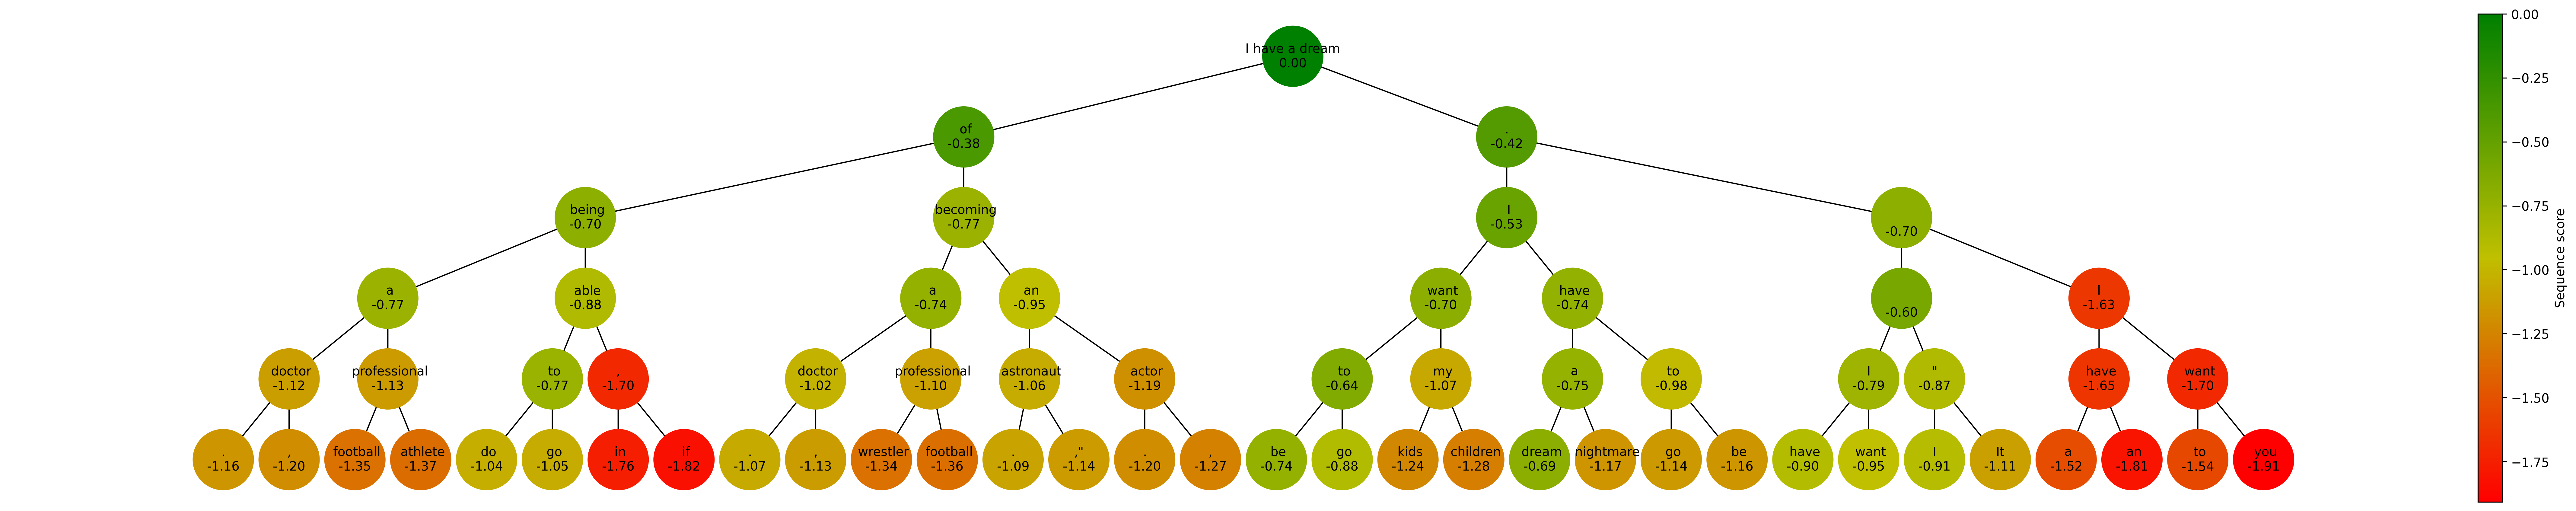

In [ ]:
plot_graph(graph, length, beams, 'sequence')

0 tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 3.7835e-44, 1.0000e+00])
1 tensor([0.0121, 0.0325, 0.0874, 0.2352, 0.6329])
2 tensor([0.0584, 0.0961, 0.1580, 0.2599, 0.4275])
3 tensor([0.0924, 0.1288, 0.1796, 0.2503, 0.3489])
4 tensor([0.1142, 0.1466, 0.1881, 0.2414, 0.3097])
5 tensor([0.1290, 0.1575, 0.1923, 0.2347, 0.2866])


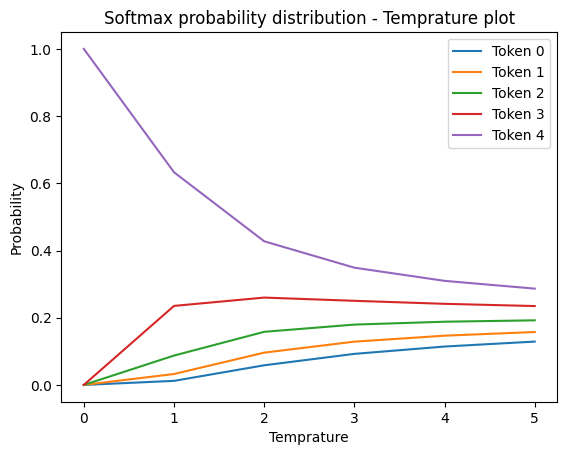

In [ ]:
from matplotlib import pyplot
import torch
#Make some data
temperatures = range(6)

#convert logits to probabilities
logits = torch.tensor([1,2,3,4,5])
prob_list = []
token_name = []
for t in temperatures:
  prob = torch.nn.functional.softmax(logits / (t + 0.01), dim=-1)
  print(t, prob)
  prob_list.append(prob.cpu().detach().numpy())
  token_name.append('Token '+ str(t))

#plot
pyplot.plot(temperatures, prob_list)
pyplot.legend(token_name,loc="upper right")
pyplot.xticks(temperatures)
pyplot.xlabel("Temprature")
pyplot.ylabel("Probability")
pyplot.title("Softmax probability distribution - Temprature plot")
pyplot.show()